In [2]:
%pip install pytorch-lightning==1.4.9

In [3]:
%pip install torchts

In [4]:
import numpy as np
import pandas as pd

import torch

from torchts.utils import data as utils
from torchts.nn.models.seq2seq import Encoder, Decoder, Seq2Seq
import torch.optim as optim

import time
from pytorch_lightning import Trainer
from pytorch_lightning import loggers as pl_loggers

In [5]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [6]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/All_Clean_Data.csv')

In [7]:
us = df[df.country == 'United States']
us = us.groupby(['day', 'origin']).size().reset_index(name='total')
us.day = pd.to_datetime(us.day)
us.day = us.day.map(lambda t: t.strftime("%Y-%m-%d"))
us = us.rename(columns={'day':'timestamp'})

In [8]:
us.total.unique()

array([  2,   1,   5,   6,  19,   4,   7,   3,  25,  13,  77,  26,   8,
       131,  12,  56,  33,  46, 122,  94,  83,  15,  70,  14, 128,  42,
       123,  27,  16,  68,  10,  81,  47,  43,  73,  17,  20,  44, 143,
       113,  28,  21,   9,  29,  96, 129,  75,  37,  58, 133, 105,  80,
        85, 138,  49, 139,  36,  66,  48,  98,  54,  84,  24, 141,  23,
        30,  22, 111,  11,  59,  55, 119,  39, 116,  41,  63,  45,  57,
        79,  18,  52, 100,  35, 109,  34, 101, 126,  40, 134, 152,  72,
       108,  51,  91, 149, 104,  31,  74, 136,  82, 103,  76, 146, 121,
       150,  50,  38, 137, 153, 140, 169,  61, 145,  53, 144, 115,  62,
       110, 130, 135, 132,  64,  87,  92,  88,  32, 166, 164, 160, 112,
       148, 159, 168, 158,  60, 118, 125,  89,  90,  78,  65,  86, 102,
       180, 165, 162, 181,  99,  93, 114, 173, 171,  95, 117, 182, 154,
        71, 120, 192, 172, 176, 124, 106, 107, 127, 161,  97, 142, 174,
       155,  67, 175, 178, 179, 156, 157, 187,  69, 185, 177, 18

**Generate seq2seq sequence**

In [9]:
def generate_seq2seq_data(df, horizon, window, features):
    
    idx_cols = ['origin','timestamp']

    df = df.set_index(idx_cols).sort_values(by=idx_cols)

    features_tensor_list = []
    for f in features:
        print(f)
        
        ts_seq_list = []
        for s in df.index.unique(level=0): # concatenate stations next to each other
#             print(s)
            values = df.loc[s][f].values
            
            for i in range(len(values)-horizon*2):
                arr = np.array(values[i:i+horizon*2])
                ts_seq_list.append(torch.from_numpy(arr.reshape(horizon*2,1)))

        sequence_tensor = torch.stack(ts_seq_list, dim=0)

        features_tensor_list.append(sequence_tensor)

    return torch.cat(features_tensor_list, dim=2)

In [10]:
%%time
data_seq2seq = generate_seq2seq_data(us,
                                     horizon=12, 
                                     window=1, 
                                     features=['total'])

print(data_seq2seq.shape)

total
torch.Size([105149, 24, 1])
CPU times: user 1.21 s, sys: 65.3 ms, total: 1.27 s
Wall time: 1.29 s


**Train, Validation, and Test Split**


In [11]:
# generate x and y vectors
x = data_seq2seq[:, :12, :]
y = data_seq2seq[:, 12:, :]

print(x.shape, y.shape)

torch.Size([105149, 12, 1]) torch.Size([105149, 12, 1])


In [12]:
# define split ratio for train, val and test
num_samples = x.shape[0]
num_test = round(num_samples * 0.2)
num_train = round(num_samples * 0.7)
num_val = num_samples - num_test - num_train

print('Total number of samples: {}'.format(num_samples))
print('Percentage for train: {:.2f}'.format(100*num_train/num_samples))
print('Percentage for val: {:.2f}'.format(100*num_val/num_samples))
print('Percentage for test: {:.2f}'.format(100*num_test/num_samples))

Total number of samples: 105149
Percentage for train: 70.00
Percentage for val: 10.00
Percentage for test: 20.00


In [13]:
# train
x_train = x[:num_train]
y_train = y[:num_train]

# val
x_val = x[num_train: num_train + num_val] 
y_val = y[num_train: num_train + num_val]

# test
x_test = x[-num_test:] 
y_test = y[-num_test:]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

torch.Size([73604, 12, 1]) torch.Size([73604, 12, 1])
torch.Size([10515, 12, 1]) torch.Size([10515, 12, 1])
torch.Size([21030, 12, 1]) torch.Size([21030, 12, 1])


In [14]:
from os.path import join

# output train, val, and test NPZ files
output_dir = './'

for cat in ["train", "val", "test"]:
    
    _x = locals()["x_" + cat] 
    _y = locals()["y_" + cat]
    
    print(cat, "x: ", _x.shape, "y:", _y.shape)
    
    np.savez_compressed(
        join(output_dir, "%s.npz" % cat),
        x=_x,
        y=_y
    )

train x:  torch.Size([73604, 12, 1]) y: torch.Size([73604, 12, 1])
val x:  torch.Size([10515, 12, 1]) y: torch.Size([10515, 12, 1])
test x:  torch.Size([21030, 12, 1]) y: torch.Size([21030, 12, 1])


**Define seq2seq Model**

In [20]:
dataset_dir = './'
# define hyper-parameters
# learning_rate = 0.01 # this parameter is currently hard coded in the optimizer
dropout_rate = 0.8
num_layers = 2
hidden_dim = 64
input_dim = 1
output_dim = 1
horizon = 12
batch_size = 64

In [21]:
%%time
# load train, val and test NPZ files
data = utils.load_dataset(dataset_dir, batch_size=batch_size, test_batch_size=batch_size)

data.keys()

CPU times: user 86.7 ms, sys: 21.9 ms, total: 109 ms
Wall time: 183 ms


In [22]:
# instantiate seq2seq model
encoder = Encoder(input_dim, hidden_dim, num_layers, dropout_rate)
decoder = Decoder(output_dim, hidden_dim, num_layers, dropout_rate)

model = Seq2Seq(encoder, decoder, output_dim, horizon, optimizer=optim.Adam)

Train Model

In [23]:
# define lightning logger and trainner objects
tb_logger = pl_loggers.TensorBoardLogger('./logs')
trainer = Trainer(max_epochs=15, logger=tb_logger, gpus = 1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [24]:
# train
start = time.time()
trainer.fit(model, data["train_loader"], data["val_loader"])

print("Training time taken %f"%(time.time() - start), flush=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 133 K 
1 | decoder | Decoder | 199 K 
------------------------------------
332 K     Trainable params
0         Non-trainable params
332 K     Total params
1.332     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training time taken 330.283851


In [25]:
# see performance for validation dataset
trainer.validate(model, data["val_loader"])

# see performance for test dataset
trainer.test(model, data["test_loader"])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 0.05286184325814247}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 3.140943590551615e-05}
--------------------------------------------------------------------------------


[{'test_loss': 3.140943590551615e-05}]

In [26]:
# save torch pth model to file
torch.save(model, 'saved_model.pth')

In [27]:
# load model checkpoints and predict from here

# define empty model
encoder = Encoder(input_dim, hidden_dim, num_layers, dropout_rate)
decoder = Decoder(output_dim, hidden_dim, num_layers, dropout_rate)
model = Seq2Seq(encoder, decoder, output_dim, horizon, optimizer=optim.Adam)

# load model object, used local machine because of low RAM memory on Google Colab
model_obj = torch.load('saved_model.pth', map_location=torch.device('cpu'))
model.load_state_dict(model_obj.state_dict())

<All keys matched successfully>

In [28]:
%%time

# get predictions for the test dataset
input_tensor = torch.tensor(data['x_test']).float()
target_tensor = torch.tensor(data['y_test']).float()

preds = model(input_tensor, target_tensor).reshape(target_tensor.shape).detach().numpy()

print(preds.shape)

(21030, 12, 1)
CPU times: user 5.65 s, sys: 7.1 s, total: 12.8 s
Wall time: 12.7 s


In [29]:
# get float values for unscaling values
avg = (x_test.float().mean()).item()
std = (x_test.float().std()).item()

print(avg, std)

4.555706024169922 7.121828079223633


In [30]:
(x_test.float().min()).item()

1.0

In [31]:
def unscale_data(arr, avg, std):
    return arr*std+avg

In [32]:
# get unscaled y vectors
y_true = unscale_data(data["y_test"], avg, std)
y_pred = unscale_data(preds, avg, std)

print(y_true.shape)
print(y_pred.shape)

(21030, 12, 1)
(21030, 12, 1)


In [33]:
y_true

array([[[4.55570602],
        [4.55570602],
        [4.55570602],
        ...,
        [4.55570602],
        [4.55570602],
        [4.55570602]],

       [[4.55570602],
        [4.55570602],
        [4.55570602],
        ...,
        [4.55570602],
        [4.55570602],
        [4.55570602]],

       [[4.55570602],
        [4.55570602],
        [4.55570602],
        ...,
        [4.55570602],
        [4.55570602],
        [4.55570602]],

       ...,

       [[4.55570602],
        [4.55570602],
        [4.55570602],
        ...,
        [4.55570602],
        [4.55570602],
        [4.55570602]],

       [[4.55570602],
        [4.55570602],
        [4.55570602],
        ...,
        [4.55570602],
        [4.55570602],
        [4.55570602]],

       [[4.55570602],
        [4.55570602],
        [4.55570602],
        ...,
        [4.55570602],
        [4.55570602],
        [4.55570602]]])

In [34]:
def masked_mae_loss(y_pred, y_true):
    mask = (y_true != 0).float()
    mask /= mask.mean()

    loss = torch.abs(y_pred - y_true)
    loss = loss * mask
    loss[torch.isnan(loss)] = 0

    return loss.mean()

In [35]:
# find masked MAE
masked_mae = masked_mae_loss(torch.from_numpy(y_pred), torch.from_numpy(y_true))
print('Masked MAE: {:.2f}'.format(masked_mae))

Masked MAE: 0.06


(4.25, 5.0)

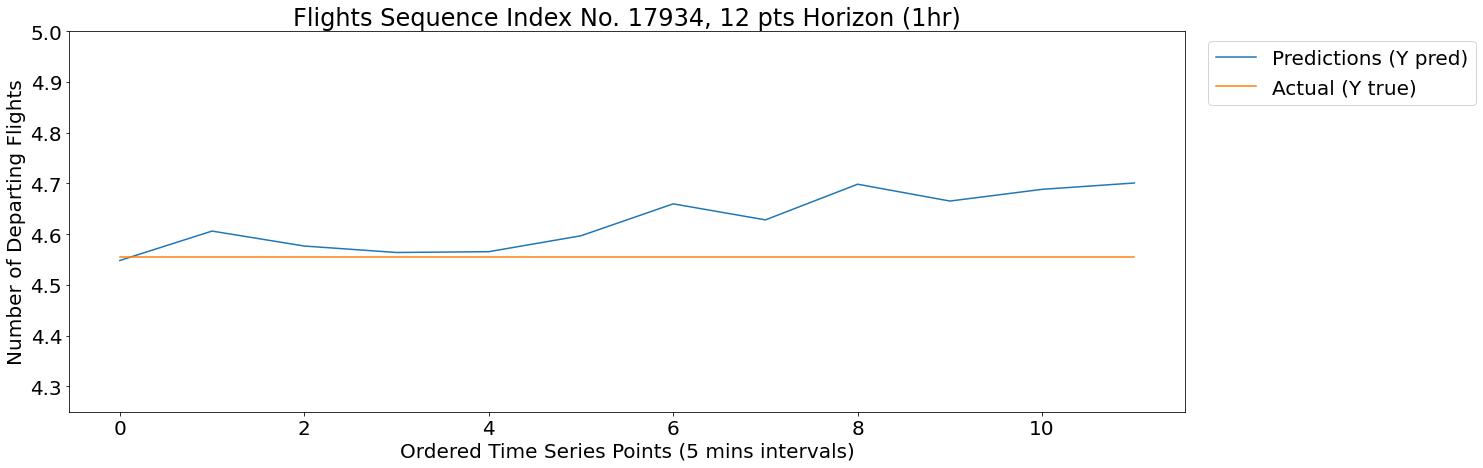

In [47]:
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

plt.figure(figsize=(20,7))
plt.rcParams.update({'font.size': 20})

sequence_index_to_plot = 17934 # specify sequence index 

plt.plot(y_pred[sequence_index_to_plot, :, 0])
plt.plot(y_true[sequence_index_to_plot, :, 0])

plt.legend(['Predictions (Y pred)', 'Actual (Y true)'], loc='upper right', bbox_to_anchor=(1.27, 1))

plt.title('Flights Sequence Index No. {}, 12 pts Horizon (1hr)'.format(sequence_index_to_plot))
plt.xlabel('Ordered Time Series Points (5 mins intervals)')
plt.ylabel('Number of Departing Flights')

axes = plt.gca()
# axes.set_xlim([xmin,xmax])
axes.set_ylim([4.25, 5])

(4.5, 4.7)

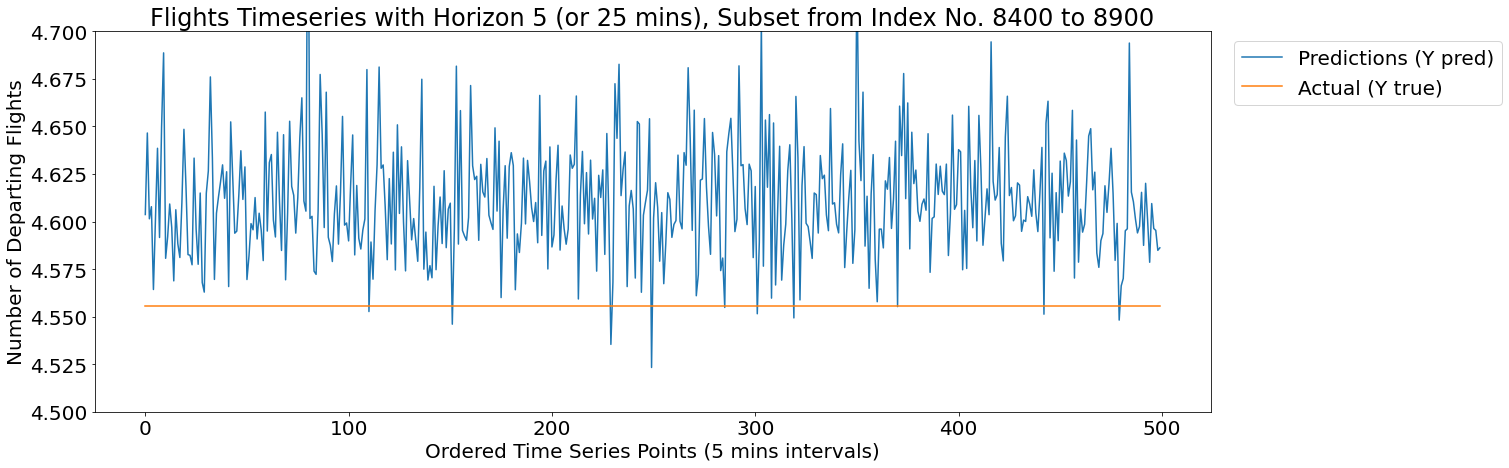

In [48]:
plt.figure(figsize=(20,7))
plt.rcParams.update({'font.size': 20})

min_sequence_index_to_plot = 8400 # min limit for x-axis
max_sequence_index_to_plot = 8900 # max limit for x-axis
horizon = 5 # select horizon, integer from 1 to 12

plt.plot(y_pred[horizon+min_sequence_index_to_plot:max_sequence_index_to_plot+horizon, horizon-1, 0])
plt.plot(y_true[min_sequence_index_to_plot:max_sequence_index_to_plot, horizon-1, 0])

plt.legend(['Predictions (Y pred)', 'Actual (Y true)'], loc='upper right', bbox_to_anchor=(1.27, 1))

plt.title("""Flights Timeseries with Horizon {} (or {} mins), \
Subset from Index No. {} to {}""".format(horizon,
                                                               horizon*5,
                                                               min_sequence_index_to_plot,
                                                               max_sequence_index_to_plot))
plt.xlabel('Ordered Time Series Points (5 mins intervals)')
plt.ylabel('Number of Departing Flights')

axes = plt.gca()
# axes.set_xlim([xmin,xmax])
axes.set_ylim([4.5,4.7])

# New Section